# Interpolation of block number and sequences

* Run this notebook to proceed the interpolation steps
* Its input is output from the disambiguation process
* Its output (record-level) will be fed into the model phase.

**Summary of the interpolation process**
1. merge census and enumeration files
2. create the sequences
3. fill in block number column
4. fill in distance sequence and enumeration distance sequence columns

### Notes

1. **`dataprocessing.all_dwellings_sequenced` creates helper columns that should be removed once finished. Otherwise, errors may occur when recalling the function or merging dfs.**

2. The output file info:
    * currently based on files [see setup]
    * dwelling level, 1850, MN
    * **block number** is filled in, looking at **distance** and **enumeration distance** sequences. Restriction is adjustable.
    * **distance** and **enumeration distance** sequences are filled in, looking at **block cluster**
    * No data on ward 12 (no address data to work with) and ward 19 (error at kmeans that I have not had a chance to look at.)

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interpolation, CensusData, dataprocessing, sequences
from interpolation import disambiguation_analysis as da
from interpolation import interpolation_fillin

from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

from interpolation import CentroidInterpolator


# 1. Setup


* Read in datasets and set column names

In [2]:
output_file_path = '../../data/census_interpolated_1850_mn_20201219.csv'

In [3]:
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v02.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_mn_20200918.csv") #For calculating centroids
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_union_20201202.csv")

filled_1850['CENSUS_PAGENUM'] = filled_1850['CENSUS_PAGENUM']//10

In [4]:
ward_col = "CENSUS_WARD_NUM"
dwelling_col = "dwelling_id"
block_col = "CD_BLOCK_NUM"
cd_ward_col = "CD_WARD_NUM"
cd_block_col = "CD_BLOCK_NUM"
dwelling_num_col = "CENSUS_DWELLING_NUM"
cd_address = "CD_H_ADDRESS"
pagenum = "CENSUS_PAGENUM"
x_col = "CD_X"
y_col = "CD_Y"


## Merge census and enumeration files

In [5]:
census_enumerators = interpolation_fillin.merge_census_enumeration(filled_1850,
                                                                   enumerators, 
                                                                   ward_col, pagenum, 
                                                                   ward_col, 'CENSUS_PAGENNO')

## Generate sequences

In [6]:
census_enum_seq = CensusData(census_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, 
                                 fixed = True, distance = True, d=0.1)

d:  0.1


# 2. Fill in block number

By checking `block number`, `distance sequence`, and `enumeration distance sequence`

In [7]:
census_all_dwellings, dwellings_sequence_with_next_info \
    = interpolation_fillin.get_dwelling_with_fillin_info(census_enum_seq, ward_col, 
                                                         dwelling_col, block_col)

In [8]:
dwellings_sequence_with_next_info.loc[dwellings_sequence_with_next_info[ward_col].isnull()].shape

(0, 50)

In [9]:
all_dwellings_3 = dataprocessing.all_dwellings_sequenced(census_all_dwellings, 
                                                         dwellings_sequence_with_next_info,
                                                         block_col = block_col, 
                                                         fill_column = block_col,
                                                         check_column = [block_col, 'sequence_id', 
                                                                         'enum_dist_id'], 
                                                         ward_col = ward_col, 
                                                         dwelling_col = dwelling_col)

## remove helper columns as mentioned at the top of the notebook
all_dwellings_3.drop(columns = ['header', 'CD_BLOCK_NUM_next', 'num_between_real'], 
                     inplace=True)



In [10]:
filled_block_num = all_dwellings_3.loc[~(all_dwellings_3['CD_BLOCK_NUM'].isnull()) & (all_dwellings_3['sequence_id'].isnull())].shape[0]
unknown_dwelling = all_dwellings_3.loc[(all_dwellings_3['sequence_id'].isnull())].shape[0]
total_dwelling = all_dwellings_3.shape[0]
print('Total Dwelling: ', total_dwelling)
print('Total Unknown Dwelling: ', unknown_dwelling)
print('Total Dwelling with filled block number: ', filled_block_num)


Total Dwelling:  38560
Total Unknown Dwelling:  22242
Total Dwelling with filled block number:  4830


## Label dwellings whose block num is filled

label dwellings whose block number isn't provided but is available becuase of the interpolation with 1. Otherwise 0.

In [11]:
all_dwellings_3['filled_block_num'] = np.where((~all_dwellings_3[block_col].isnull()) &
                                              (all_dwellings_3['sequence_id'].isnull()), 1, 0)

## Label dwellings whose address is known

label dwellings whose block number/addresses are already available with 1. Otherwise, 0. (Dwellings with known address must have distance sequence.)

In [12]:
all_dwellings_3['known_address'] = np.where(~all_dwellings_3['sequence_id'].isnull(), 1, 0)

## Remove ward 12 and 19

### 1850 CD wards with addresses
<img src="fig_1850_cd_wards.png" alt="." width="200"/>

There are 0 and 12 known dwellings in ward 12 and 19, which is too few.  These 2 wards are removed from the process.

In [13]:
all_dwellings_3 = all_dwellings_3.loc[all_dwellings_3[ward_col] != 12]
all_dwellings_3 = all_dwellings_3.loc[all_dwellings_3[ward_col] != 19]

## Get dwellings for the model

* Dwellings with interpolated block numbers are removed from the data that will be used in the model phase. We should not train a model on the data that we are not 100% certain that block numbers are correct.
* overwrite this to `census_enum_seq.df`

In [14]:
## dwellings without block num | dwelling with sequence id
census_enum_seq.df = all_dwellings_3.loc[all_dwellings_3['filled_block_num'] == 0]

In [15]:
print(all_dwellings_3.shape) ## total dwellings
print(census_enum_seq.df.shape) ## dwelling to be used in the model phase

(35735, 49)
(30911, 49)


# 3. Interpolate sequence

We need distance sequence and enumeration distance seqeunce for the model phase. We try to fill in at this step.

## Get block centroid

In [16]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby('CD_WARD_NUM')}

## Model to be used in kmeanbest

In [17]:
all_cols = ["CENSUS_SERIAL", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_GENDER", "CENSUS_RACE", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_FIRST_NAME", "CENSUS_LAST_NAME", "CENSUS_OCCUPATION", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]

transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols)])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

## Get block cluster

Need to process ward by ward.

In [18]:
ward_list = census_enum_seq.df[ward_col].unique()

n is 5 and it's the 10th iteration


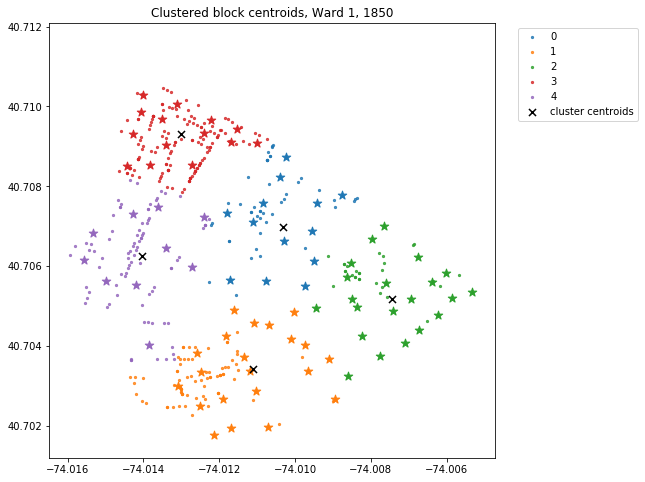

n is 5 and it's the 10th iteration


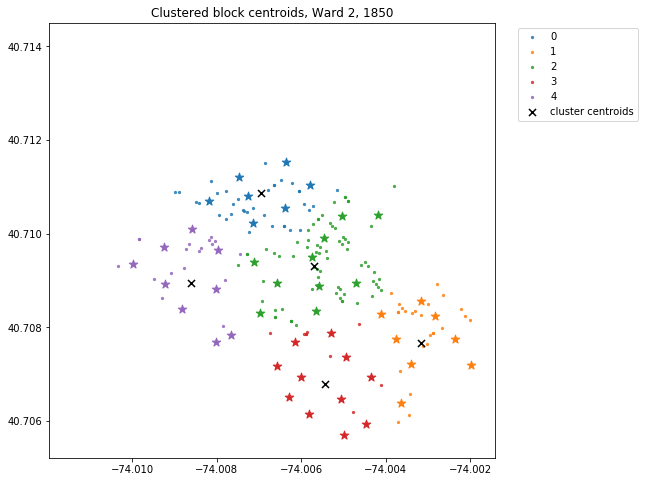

n is 5 and it's the 10th iteration


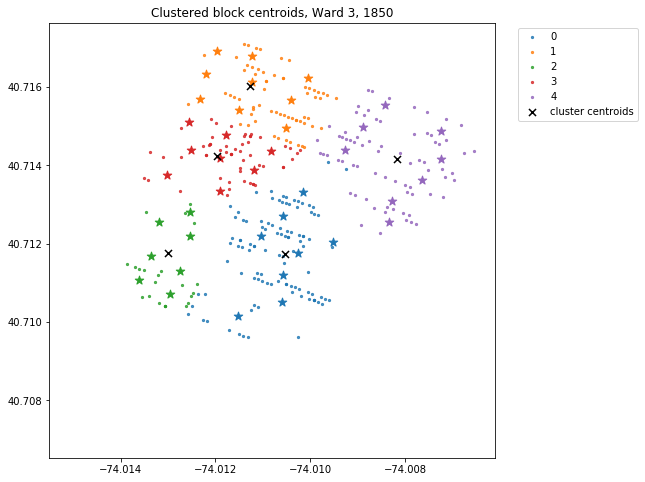

n is 5 and it's the 10th iteration


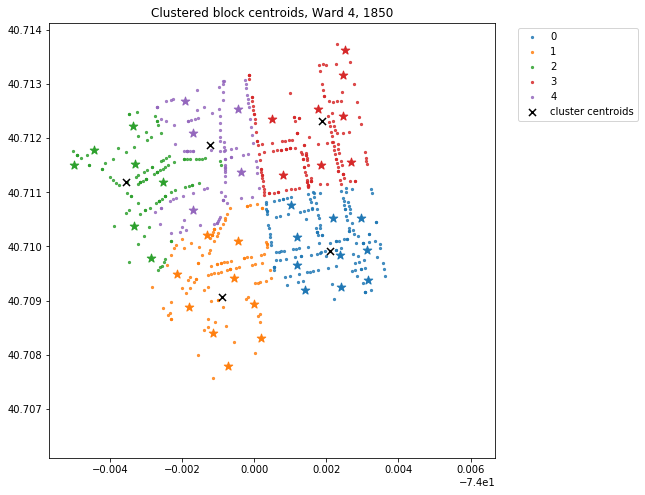

n is 5 and it's the 10th iteration


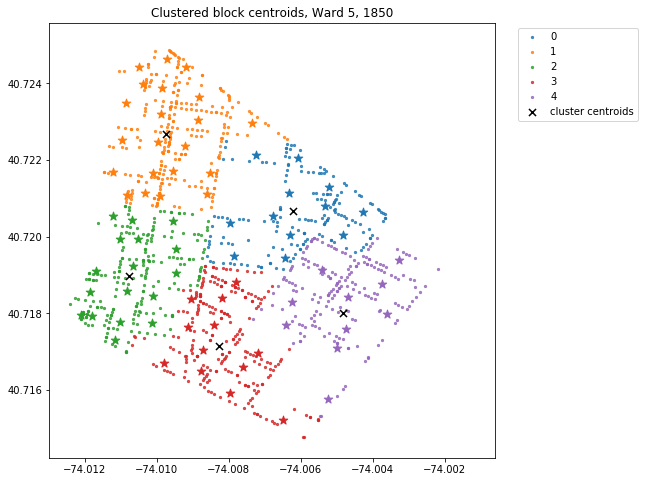

n is 5 and it's the 10th iteration


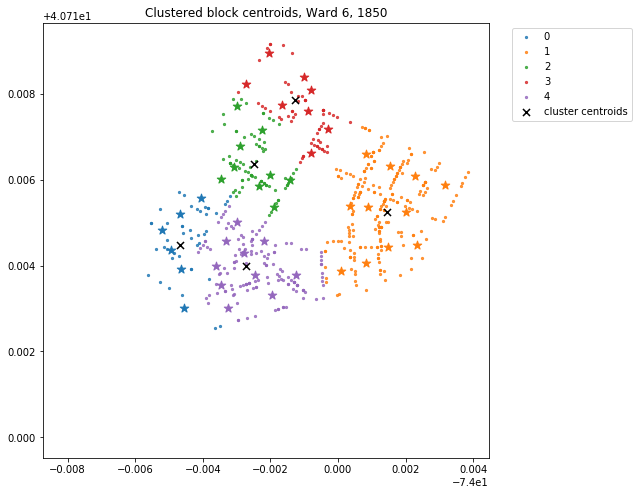

n is 5 and it's the 10th iteration


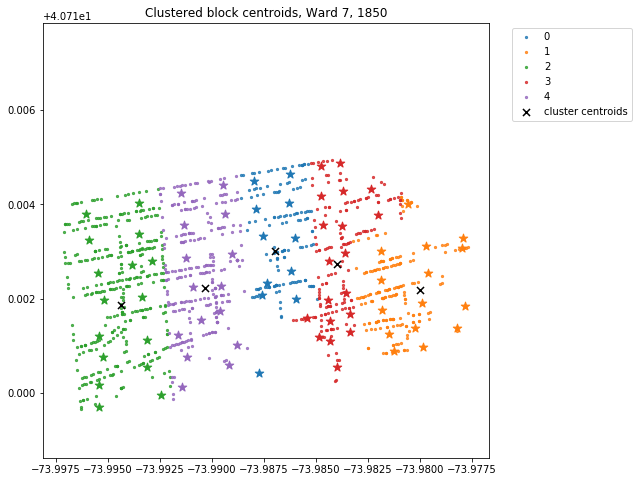

n is 5 and it's the 10th iteration


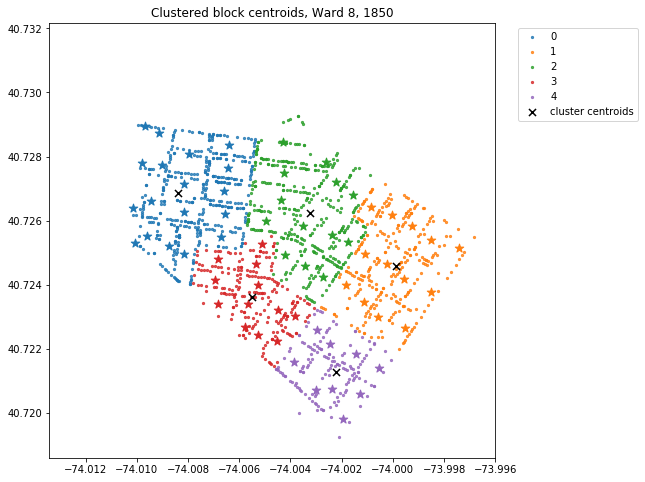

n is 5 and it's the 10th iteration


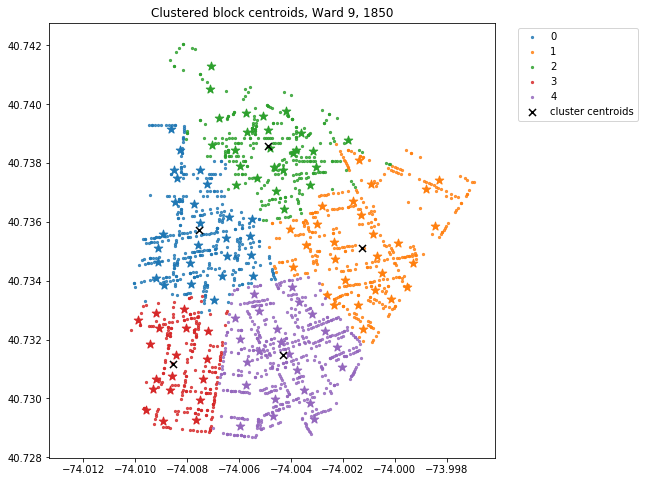

n is 5 and it's the 10th iteration


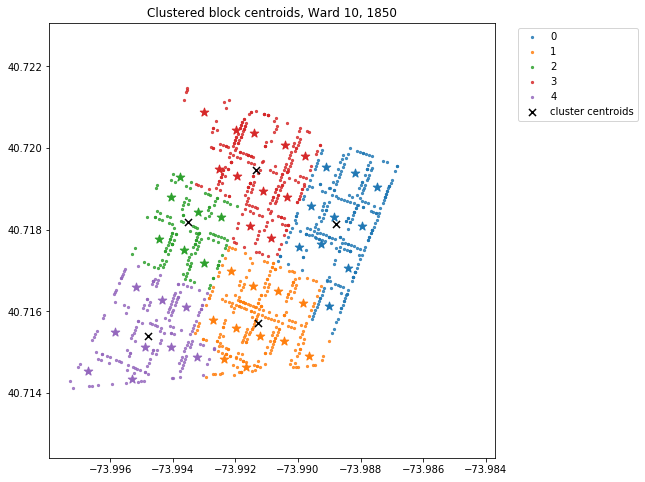

n is 5 and it's the 10th iteration


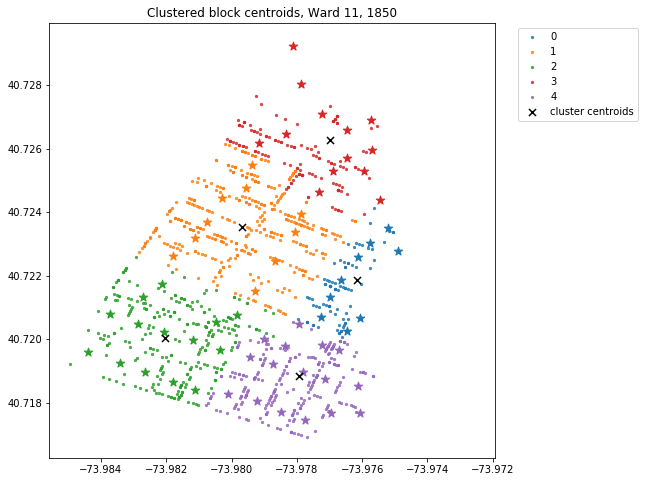

n is 5 and it's the 10th iteration


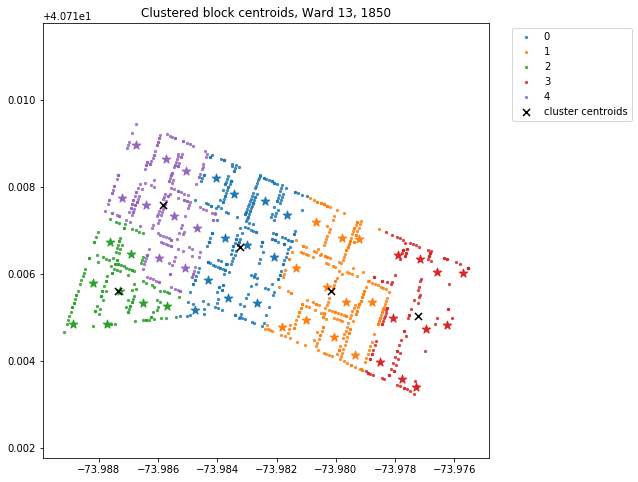

n is 5 and it's the 10th iteration


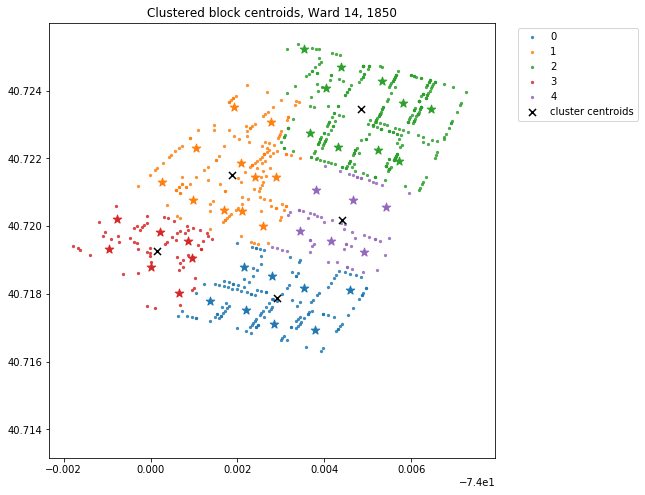

n is 5 and it's the 10th iteration


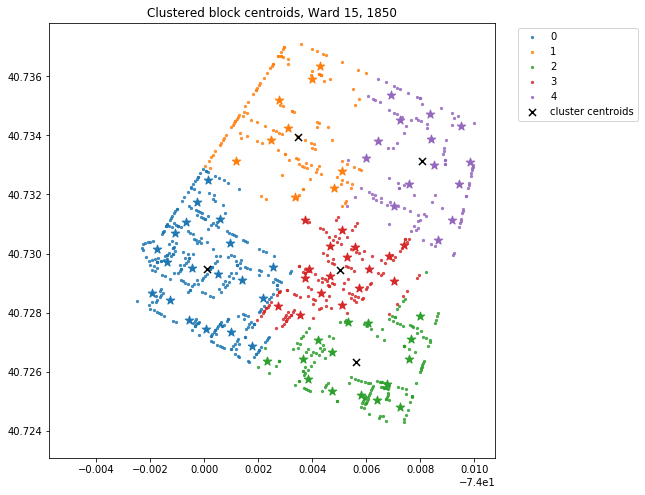

n is 5 and it's the 10th iteration


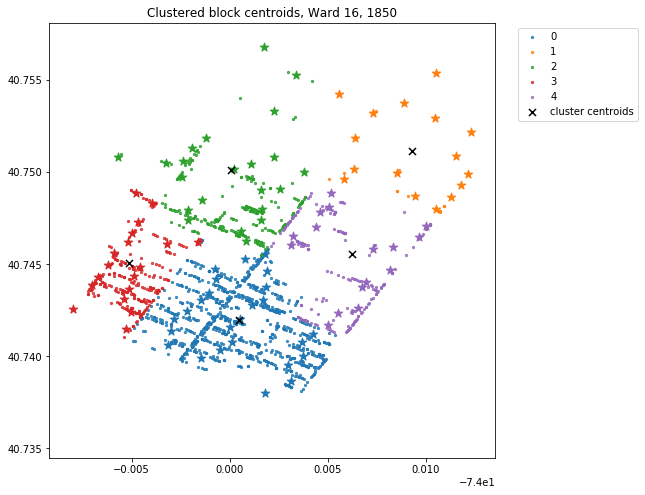

n is 5 and it's the 10th iteration


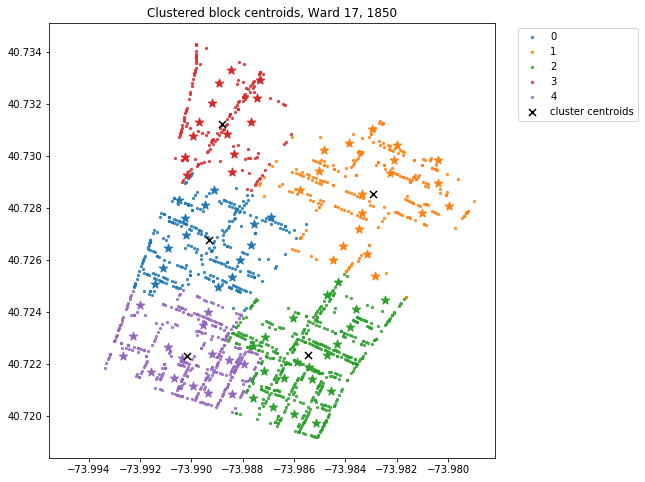

n is 5 and it's the 10th iteration


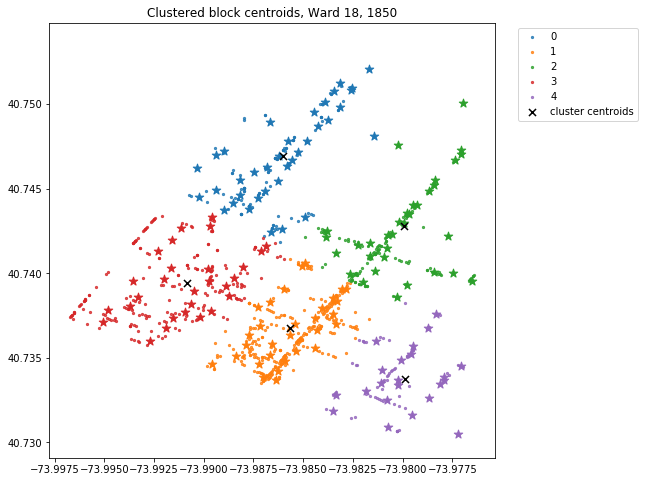

In [19]:
to_cluster_by_ward = {}
for current_ward in ward_list:
    
    ## run kmeans to get block clusters on data within current_ward
    interpolate_sequences = CentroidInterpolator(census_enum_seq, current_ward, 
                                                 pipeline, all_cols, KMeans(5), block_centroids)
    score, model = interpolate_sequences.kmeans_best(5)
    interpolate_sequences.set_clustering_algo(model)
    interpolate_sequences.apply_clustering(algo_fit = True)
    interpolate_sequences.clustervis(kmeans = True)
    
    ## get dictionary to encode from block number to cluster
    to_cluster = np.array(list(block_centroids[current_ward].values()))
    clusters = model.predict(to_cluster)
    block_num_to_cluster = {block_num: cluster for block_num, cluster in zip(block_centroids[current_ward].keys(), clusters)}

    to_cluster_by_ward[current_ward] = block_num_to_cluster


## Assign block cluster to all dwellings

In [20]:
all_dwellings_3['cluster'] = [to_cluster_by_ward[ward][blocknum] \
                              if blocknum in to_cluster_by_ward[ward].keys() \
                              else np.nan for blocknum, ward in \
                              zip(all_dwellings_3[block_col], all_dwellings_3[ward_col])]


## Overwrite the new data to census_enum_seq.df

Now `census_enum_seq.df` contains all dwellings, including dwellings with previously interpolated block numbers.

In [21]:
census_enum_seq.df = all_dwellings_3

## Fill in distance sequence

* drop `enum_dist_id` column. It will be recreated later.

In [22]:
census_all_dwellings, dwellings_sequence_with_next_info \
    = interpolation_fillin.get_dwelling_with_fillin_info(census_enum_seq, ward_col, 
                                                         dwelling_col, 'sequence_id')
## only check on sequence col
all_dwellings_dist_seq = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = 'sequence_id',
                                                       check_column = ['cluster', 'sequence_id'], ward_col = ward_col, 
                                                              dwelling_col = dwelling_col)
## remove helper columns as mentioned at the top of the notebook
## Drop `enum_dist_id`. To be created later
all_dwellings_dist_seq.drop(columns = ['header', 'sequence_id_next', 'num_between_real', 'enum_dist_id'], 
                     inplace=True)


## Fill in enumeration distance sequence

In [23]:
census_all_dwellings, dwellings_sequence_with_next_info \
    = interpolation_fillin.get_dwelling_with_fillin_info(census_enum_seq, ward_col, 
                                                         dwelling_col, 'enum_dist_id')


## only check on sequence col
all_dwellings_enum_dist_seq = dataprocessing.all_dwellings_sequenced(census_all_dwellings, dwellings_sequence_with_next_info, 
                                                       block_col = block_col, fill_column = 'enum_dist_id',
                                                       check_column = ['cluster', 'enum_dist_id'], ward_col = ward_col,
                                                              dwelling_col = dwelling_col)
# remove the other sequence col. To be filled later.
all_dwellings_enum_dist_seq = all_dwellings_enum_dist_seq[[dwelling_col, 'enum_dist_id']]


## Combine new distance and enumeration distance sequence dfs

In [24]:
all_dwellings_filled_seq = all_dwellings_dist_seq.copy()
all_dwellings_filled_seq['enum_dist_id'] = all_dwellings_enum_dist_seq['enum_dist_id']

## Label dwellings with filled in sequences

In [25]:
## with sequence id but no block num
all_dwellings_filled_seq['filled_sequence_id'] = \
    np.where(~all_dwellings_filled_seq['sequence_id'].isnull() &\
            all_dwellings_filled_seq[block_col].isnull(), 1, 0)

## with enum dist id but no block num
all_dwellings_filled_seq['filled_enum_dist_id'] = \
    np.where(~all_dwellings_filled_seq['enum_dist_id'].isnull() &\
            all_dwellings_filled_seq[block_col].isnull(), 1, 0)

# 4. Report result at dwelling level

In [26]:
total_dwellings = all_dwellings_filled_seq.groupby(ward_col)['dwelling_id'].agg('count')
known_dwellings = all_dwellings_filled_seq.groupby(ward_col)['known_address'].agg('sum')
filled_block_num_dwellings = all_dwellings_filled_seq.groupby(ward_col)['filled_block_num'].agg('sum')
filled_distance_seq_dwellings = all_dwellings_filled_seq.groupby(ward_col)['filled_sequence_id'].agg('sum')
filled_enum_dist_seq_dwellings = all_dwellings_filled_seq.groupby(ward_col)['filled_enum_dist_id'].agg('sum')
left_over = all_dwellings_filled_seq.loc[(all_dwellings_filled_seq[block_col].isnull()) & 
                     ((all_dwellings_filled_seq['filled_sequence_id'] == 0) | 
                      (all_dwellings_filled_seq['filled_enum_dist_id'] == 0))].groupby(ward_col)['dwelling_id'].agg('count')
                                

In [27]:
## distance seq is always interpolated if enum_dist seq is. Must be 0.
all_dwellings_filled_seq.loc[(all_dwellings_filled_seq['filled_sequence_id'] == 0) & (all_dwellings_filled_seq['filled_enum_dist_id'] == 1)].shape[0]


0

In [28]:
report = pd.DataFrame([known_dwellings, filled_block_num_dwellings, 
                       filled_distance_seq_dwellings, filled_enum_dist_seq_dwellings, 
                       left_over])/total_dwellings*100
report = report.T
report.rename(columns={'dwelling_id': 'left_over'}, inplace=True)
report['complete_seq'] = report['filled_enum_dist_id']
report['only_distance_seq'] = report['filled_sequence_id'] - report['filled_enum_dist_id']


In [29]:
report

,known_address,filled_block_num,filled_sequence_id,filled_enum_dist_id,left_over,complete_seq,only_distance_seq
CENSUS_WARD_NUM,,,,,,,
1,34.883721,6.883721,15.720930,7.627907,50.604651,7.627907,8.093023
2,24.307692,7.076923,29.384615,17.076923,51.538462,17.076923,12.307692
3,43.365253,15.184679,14.363885,8.071135,33.378933,8.071135,6.292750
4,51.620746,15.478120,14.181524,2.269044,30.632091,2.269044,11.912480
5,52.420949,17.243083,10.177866,4.693676,25.642292,4.693676,5.484190
6,38.061297,16.108339,14.255167,6.557377,39.272986,6.557377,7.697790
7,43.318708,18.907060,10.251296,5.504587,32.269645,5.504587,4.746709
8,53.532411,17.115805,9.031318,4.734159,24.617626,4.734159,4.297160
9,50.457928,14.911276,9.101317,6.410990,28.219805,6.410990,2.690326


Text(0, 0.5, '%')

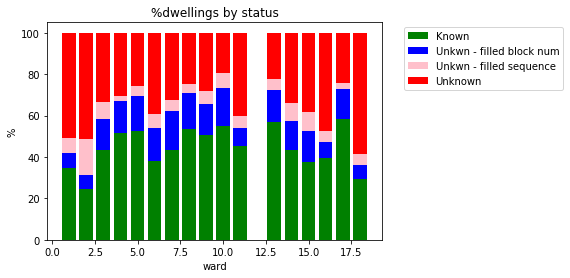

In [30]:
fig, ax = plt.subplots(1,1)

p1 = ax.bar(ward_list, report['known_address'], color='g')
p2 = ax.bar(ward_list, report['filled_block_num'], 
       bottom=report['known_address'], color='b')
p3 = ax.bar(ward_list, report['complete_seq'], 
       bottom=report['known_address'] + report['filled_block_num'], color='pink')
p4 = ax.bar(ward_list, report['left_over'], 
       bottom=report['known_address'] + report['filled_block_num'] + report['complete_seq'], color='r')
ax.legend([p1,p2,p3,p4], ['Known','Unkwn - filled block num', 
                          'Unkwn - filled sequence','Unknown'],
         bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('%dwellings by status')
ax.set_xlabel('ward')
ax.set_ylabel('%')

# 5. Turn into record-level and export data

In [31]:
census_1850_filled_seq = filled_1850.merge(all_dwellings_filled_seq, how='left')

Sanity check of merging.

In [32]:
assert census_1850_filled_seq.shape[0] == filled_1850.shape[0], 'not properly merged'
assert census_1850_filled_seq.shape[1] == all_dwellings_filled_seq.shape[1], 'contain same columns with different names'

In [33]:
census_1850_filled_seq.to_csv(output_file_path, index=False)